## Step 1: Installations

In [1]:
!pip install /kaggle/input/wheelhouse-cibmtr/torchsurv-0.1.4-py3-none-any.whl
!pip install lifelines -q --no-index --find-links=/kaggle/input/cibmtr2024-import/lifelines
!pip install scikit-learn -q --no-index --find-links=/kaggle/input/wheelhouse-cibmtr/scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

Processing /kaggle/input/wheelhouse-cibmtr/torchsurv-0.1.4-py3-none-any.whl
  Preparing metadata (setup.py) ... done


## Step 2: Imports

In [2]:
import os
import gc
import torch
import copy
import warnings
import lifelines
import pandas as pd
import numpy as np
from tqdm import tqdm
from metric import score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, PredefinedSplit
warnings.filterwarnings("ignore")

from torchsurv.loss.cox import neg_partial_log_likelihood
from torchsurv.loss.weibull import neg_log_likelihood, log_hazard, survival_function
from torchsurv.metrics.brier_score import BrierScore
from torchsurv.metrics.cindex import ConcordanceIndex
from torchsurv.metrics.auc import Auc
from torchsurv.stats.kaplan_meier import KaplanMeierEstimator

print(f"torch version: {torch.__version__}")
print(f"lifelines version: {lifelines.__version__}")

torch version: 2.5.1+cu121
lifelines version: 0.30.0


# 2. Configuration

In [3]:
class config:
    root = "/kaggle/input/equity-post-HCT-survival-predictions"
    train_path = "/kaggle/input/cibmtr-2024-dataset/random_folding.xlsx"
    test_path = os.path.join(root, "test.csv")
    sub_path = os.path.join(root, "sample_submission.csv")
    seed = 42
    n_folds = 5
    epochs = 20
    batch_size = 2048
    learning_rate = 1e-3

# 3. Loading & Preprocessing Data

In [4]:
def add_features(df):
    """
    Create some new features to help the model focus on specific patterns.
    """
    df['is_cyto_score_same'] = (df['cyto_score'] == df['cyto_score_detail']).astype(int)
    df['year_hct'] -= 2000
    
    return df

train_df = pd.read_excel(config.train_path)
eval_df = train_df[["ID", "efs", "efs_time", "race_group"]].copy()
test_df = pd.read_csv(config.test_path)

train_df = add_features(train_df)
test_df = add_features(test_df)

target_cols = ["efs", "efs_time"]
drop_cols = ["ID"]

cat_cols = [col for col in train_df.select_dtypes(include=["object"]).columns if col not in target_cols + drop_cols]
num_cols = [col for col in train_df.columns if col not in cat_cols + target_cols + drop_cols]

print(f"cat_cols: {len(cat_cols)}")
print(f"num_cols: {len(num_cols)}")

# Categorical Features
for col in cat_cols:
    train_df[col].fillna("Unknown", inplace=True)
    test_df[col].fillna("Unknown", inplace=True)

    labels = train_df[col].unique()
    for i in labels:
        train_df[f"{col}_{i}"] = train_df[col].apply(lambda x: 1 if x == i else 0)
        test_df[f"{col}_{i}"] = test_df[col].apply(lambda x: 1 if x == i else 0)

    if col != "race_group":
        train_df.drop(columns=[col], axis=1, inplace=True)
    test_df.drop(columns=[col], axis=1, inplace=True)

# Numerical Features
for col in num_cols:
    if col != "fold":
        imputer = SimpleImputer(strategy='mean')
        train_df[col] = imputer.fit_transform(train_df[col].values.reshape(-1, 1))
        test_df[col] = imputer.transform(test_df[col].values.reshape(-1, 1))

train_df = train_df.drop(columns=drop_cols, axis=1)
test_df = test_df.drop(columns=drop_cols, axis=1)

print(f"train: {train_df.shape}")
print(f"test: {test_df.shape}")

train_df.head()

cat_cols: 35
num_cols: 24
train: (28800, 218)
test: (3, 214)


,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,...,melphalan_dose_MEL,melphalan_dose_Unknown,cardiac_No,cardiac_Yes,cardiac_Not done,cardiac_Unknown,pulm_moderate_No,pulm_moderate_Yes,pulm_moderate_Not done,pulm_moderate_Unknown
0,1.764516,6.876801,6.0,6.0,8.61723,2.0,6.0,2.0,2.0,2.0,...,0,0,1,0,0,0,1,0,0,0
1,2.000000,8.000000,6.0,6.0,10.00000,2.0,6.0,2.0,2.0,2.0,...,0,0,1,0,0,0,0,1,0,0
2,2.000000,8.000000,6.0,6.0,10.00000,2.0,6.0,2.0,2.0,2.0,...,0,0,1,0,0,0,1,0,0,0
3,2.000000,8.000000,6.0,6.0,10.00000,2.0,6.0,2.0,2.0,2.0,...,0,0,1,0,0,0,1,0,0,0
4,2.000000,8.000000,6.0,6.0,10.00000,2.0,5.0,2.0,2.0,2.0,...,1,0,1,0,0,0,1,0,0,0


In [5]:
if "fold" in list(train_df.columns):
    print("Yessss")

Yessss


# 4. Creating Cross-Validation Folds

In [6]:
print(train_df["fold"].value_counts().sort_index())

train_df = train_df.drop(columns=["race_group"], axis=1)
test_df["efs"] = np.nan
test_df["efs_time"] = np.nan

scaler = StandardScaler()
inputs = [col for col in train_df.columns if col not in target_cols and col !="fold"]
train_df[inputs] = scaler.fit_transform(train_df[inputs])
test_df[inputs] = scaler.transform(test_df[inputs])

fold
0    2880
1    2880
2    2880
3    2880
4    2880
5    2880
6    2880
7    2880
8    2880
9    2880
Name: count, dtype: int64


In [7]:
if "fold" in list(train_df.columns):
    print("Yessss")

Yessss


# 5. Modeling

In [8]:
class Custom_dataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        event = torch.tensor(sample["efs"]).bool()
        time = torch.tensor(sample["efs_time"]).float()
        x = torch.tensor(sample.drop(["efs", "efs_time"]).values).float()
        return x, (event, time)

def load_cox_model(num_features: int):
    cox_model = torch.nn.Sequential(
        torch.nn.BatchNorm1d(num_features),
        torch.nn.Linear(num_features, 32),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.2, inplace=False),
        torch.nn.Linear(32, 64),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.2, inplace=False),
        torch.nn.Linear(64, 1),
    )
    return cox_model

def plot_losses(train_losses: list, val_losses: list, title: str = "Cox") -> None:
    train_losses = torch.stack(train_losses) / train_losses[0]
    val_losses = torch.stack(val_losses) / val_losses[0]
    plt.plot(train_losses, label="training")
    plt.plot(val_losses, label="validation")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Normalized loss")
    plt.title(title)
    plt.yscale("log")
    plt.show()

def train_model(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    dataloader_train: torch.utils.data.DataLoader,
    dataloader_val: torch.utils.data.DataLoader,
    epochs: int,
    plot: bool = True
):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float("inf")
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        epoch_loss = torch.tensor(0.0)
        for i, batch in enumerate(dataloader_train):
            x, (event, time) = batch
            optimizer.zero_grad()
            log_hz = cox_model(x)
            loss = neg_partial_log_likelihood(log_hz, event, time, reduction="mean")
            loss.backward()
            optimizer.step()
            epoch_loss += loss.detach()
        epoch_loss /= i + 1

        with torch.no_grad():
            x, (event, time) = next(iter(dataloader_val))
            val_loss = neg_partial_log_likelihood(cox_model(x), event, time, reduction="mean")
            val_losses.append(val_loss)
            
        print(f"Epoch: {epoch}, Train Loss: {epoch_loss:.5f} Val Loss: {val_loss:.5f}")
        train_losses.append(epoch_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)

    if plot:
        plot_losses(train_losses, val_losses, "Cox")

    return model

def infer(model: torch.nn.Module, dataloader_test: torch.utils.data.DataLoader):
    model.eval()
    with torch.no_grad():
        x, (event, time) = next(iter(dataloader_test))
        log_hz = model(x)
    return log_hz, event, time

def validate_model(data: pd.DataFrame, preds):
    y_true = data[['ID', 'efs', 'efs_time', 'race_group']].copy()
    y_pred = data[['ID']].copy()
    y_pred['prediction'] = preds
    c_index_score = score(y_true.copy(), y_pred.copy(), 'ID')
    return c_index_score

========================================| Fold 1 |========================================
Epoch: 0, Train Loss: 7.74767 Val Loss: 8.21843
Epoch: 1, Train Loss: 7.61670 Val Loss: 8.16719
Epoch: 2, Train Loss: 7.58496 Val Loss: 8.13624
Epoch: 3, Train Loss: 7.57938 Val Loss: 8.10565
Epoch: 4, Train Loss: 7.57007 Val Loss: 8.11052
Epoch: 5, Train Loss: 7.54404 Val Loss: 8.10694
Epoch: 6, Train Loss: 7.54777 Val Loss: 8.10058
Epoch: 7, Train Loss: 7.55698 Val Loss: 8.10936
Epoch: 8, Train Loss: 7.52640 Val Loss: 8.10324
Epoch: 9, Train Loss: 7.51769 Val Loss: 8.10431
Epoch: 10, Train Loss: 7.52056 Val Loss: 8.10104
Epoch: 11, Train Loss: 7.51589 Val Loss: 8.10936
Epoch: 12, Train Loss: 7.50497 Val Loss: 8.09410
Epoch: 13, Train Loss: 7.50832 Val Loss: 8.10190
Epoch: 14, Train Loss: 7.52349 Val Loss: 8.11547
Epoch: 15, Train Loss: 7.51034 Val Loss: 8.11150
Epoch: 16, Train Loss: 7.51851 Val Loss: 8.10182
Epoch: 17, Train Loss: 7.49212 Val Loss: 8.10183
Epoch: 18, Train Loss: 7.52194 Val Lo

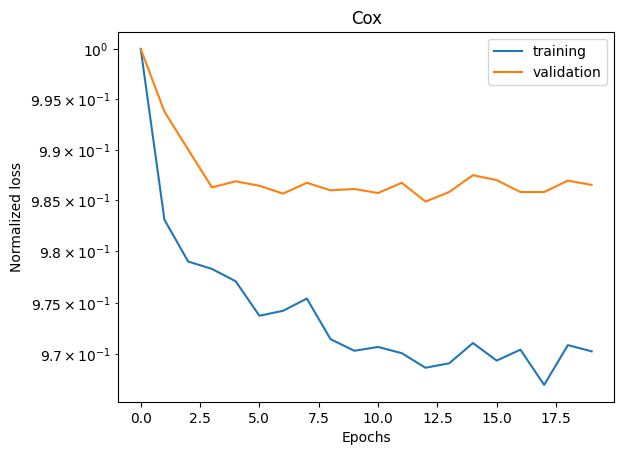

Model saved to cox_model_fold_0.pt
C-Index: 0.67077
Stratified C-Index: 0.64957
Confidence Interval: tensor([0.6431, 0.6984])

========================================| Fold 2 |========================================
Epoch: 0, Train Loss: 7.76305 Val Loss: 8.31216
Epoch: 1, Train Loss: 7.66140 Val Loss: 8.24028
Epoch: 2, Train Loss: 7.59178 Val Loss: 8.20425
Epoch: 3, Train Loss: 7.55345 Val Loss: 8.18949
Epoch: 4, Train Loss: 7.56133 Val Loss: 8.18286
Epoch: 5, Train Loss: 7.54705 Val Loss: 8.17504
Epoch: 6, Train Loss: 7.54214 Val Loss: 8.16932
Epoch: 7, Train Loss: 7.53390 Val Loss: 8.18429
Epoch: 8, Train Loss: 7.51184 Val Loss: 8.16848
Epoch: 9, Train Loss: 7.53705 Val Loss: 8.17216
Epoch: 10, Train Loss: 7.51374 Val Loss: 8.17187
Epoch: 11, Train Loss: 7.53422 Val Loss: 8.17207
Epoch: 12, Train Loss: 7.52287 Val Loss: 8.16940
Epoch: 13, Train Loss: 7.49769 Val Loss: 8.17145
Epoch: 14, Train Loss: 7.52921 Val Loss: 8.18281
Epoch: 15, Train Loss: 7.49066 Val Loss: 8.17653
Epoch: 1

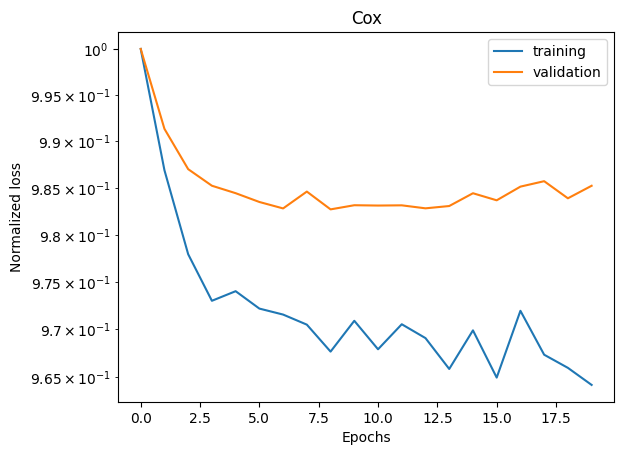

Model saved to cox_model_fold_1.pt
C-Index: 0.67426
Stratified C-Index: 0.65533
Confidence Interval: tensor([0.6475, 0.7010])

========================================| Fold 3 |========================================
Epoch: 0, Train Loss: 7.69692 Val Loss: 8.34968
Epoch: 1, Train Loss: 7.64953 Val Loss: 8.28869
Epoch: 2, Train Loss: 7.60751 Val Loss: 8.26362
Epoch: 3, Train Loss: 7.61013 Val Loss: 8.24783
Epoch: 4, Train Loss: 7.57421 Val Loss: 8.24241
Epoch: 5, Train Loss: 7.56096 Val Loss: 8.22909
Epoch: 6, Train Loss: 7.56652 Val Loss: 8.22972
Epoch: 7, Train Loss: 7.53725 Val Loss: 8.23145
Epoch: 8, Train Loss: 7.52098 Val Loss: 8.24168
Epoch: 9, Train Loss: 7.51653 Val Loss: 8.22789
Epoch: 10, Train Loss: 7.52020 Val Loss: 8.22850
Epoch: 11, Train Loss: 7.53325 Val Loss: 8.23226
Epoch: 12, Train Loss: 7.52136 Val Loss: 8.23858
Epoch: 13, Train Loss: 7.49536 Val Loss: 8.23414
Epoch: 14, Train Loss: 7.49658 Val Loss: 8.23561
Epoch: 15, Train Loss: 7.52020 Val Loss: 8.24028
Epoch: 1

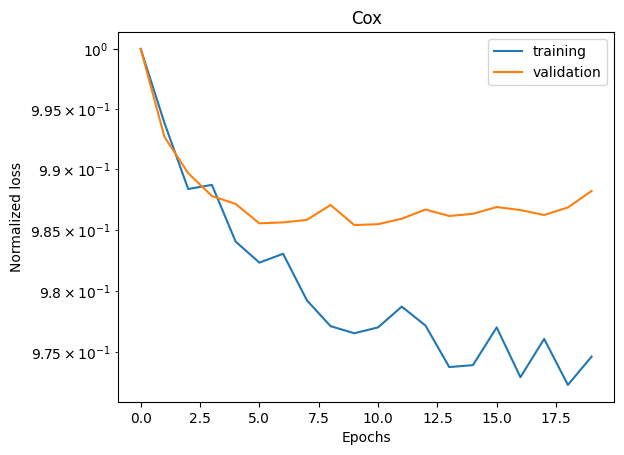

Model saved to cox_model_fold_2.pt
C-Index: 0.67458
Stratified C-Index: 0.65353
Confidence Interval: tensor([0.6475, 0.7017])

========================================| Fold 4 |========================================
Epoch: 0, Train Loss: 7.72141 Val Loss: 8.31827
Epoch: 1, Train Loss: 7.60900 Val Loss: 8.25924
Epoch: 2, Train Loss: 7.61459 Val Loss: 8.23825
Epoch: 3, Train Loss: 7.60089 Val Loss: 8.21851
Epoch: 4, Train Loss: 7.57137 Val Loss: 8.21035
Epoch: 5, Train Loss: 7.56257 Val Loss: 8.21179
Epoch: 6, Train Loss: 7.55073 Val Loss: 8.20216
Epoch: 7, Train Loss: 7.53787 Val Loss: 8.19363
Epoch: 8, Train Loss: 7.51064 Val Loss: 8.21106
Epoch: 9, Train Loss: 7.50508 Val Loss: 8.20615
Epoch: 10, Train Loss: 7.56578 Val Loss: 8.19387
Epoch: 11, Train Loss: 7.54466 Val Loss: 8.19491
Epoch: 12, Train Loss: 7.53057 Val Loss: 8.20043
Epoch: 13, Train Loss: 7.52526 Val Loss: 8.19770
Epoch: 14, Train Loss: 7.49121 Val Loss: 8.21481
Epoch: 15, Train Loss: 7.47744 Val Loss: 8.19368
Epoch: 1

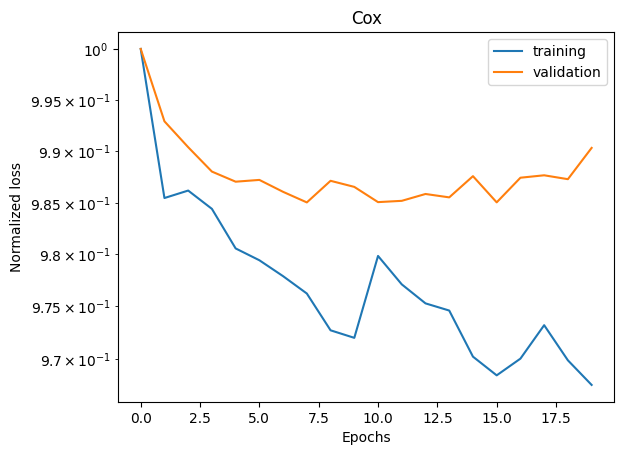

Model saved to cox_model_fold_3.pt
C-Index: 0.66975
Stratified C-Index: 0.64597
Confidence Interval: tensor([0.6434, 0.6961])

========================================| Fold 5 |========================================
Epoch: 0, Train Loss: 7.72005 Val Loss: 8.30377
Epoch: 1, Train Loss: 7.65864 Val Loss: 8.22935
Epoch: 2, Train Loss: 7.63421 Val Loss: 8.20777
Epoch: 3, Train Loss: 7.58453 Val Loss: 8.19601
Epoch: 4, Train Loss: 7.57827 Val Loss: 8.18949
Epoch: 5, Train Loss: 7.56863 Val Loss: 8.19217
Epoch: 6, Train Loss: 7.53986 Val Loss: 8.18112
Epoch: 7, Train Loss: 7.55109 Val Loss: 8.17384
Epoch: 8, Train Loss: 7.53428 Val Loss: 8.17461
Epoch: 9, Train Loss: 7.52113 Val Loss: 8.18230
Epoch: 10, Train Loss: 7.53333 Val Loss: 8.18414
Epoch: 11, Train Loss: 7.53388 Val Loss: 8.17464
Epoch: 12, Train Loss: 7.52587 Val Loss: 8.17209
Epoch: 13, Train Loss: 7.51523 Val Loss: 8.18008
Epoch: 14, Train Loss: 7.50291 Val Loss: 8.18805
Epoch: 15, Train Loss: 7.51801 Val Loss: 8.18773
Epoch: 1

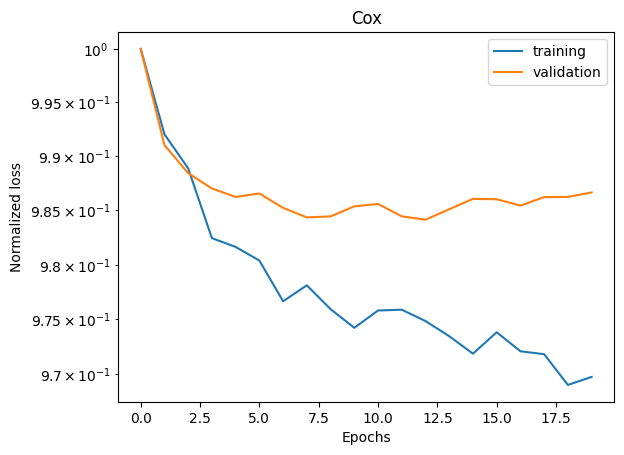

Model saved to cox_model_fold_4.pt
C-Index: 0.67093
Stratified C-Index: 0.64575
Confidence Interval: tensor([0.6439, 0.6980])

========================================| Fold 6 |========================================
Epoch: 0, Train Loss: 7.76069 Val Loss: 8.29493
Epoch: 1, Train Loss: 7.66117 Val Loss: 8.20583
Epoch: 2, Train Loss: 7.61597 Val Loss: 8.18414
Epoch: 3, Train Loss: 7.56871 Val Loss: 8.17991
Epoch: 4, Train Loss: 7.55803 Val Loss: 8.16884
Epoch: 5, Train Loss: 7.56864 Val Loss: 8.15705
Epoch: 6, Train Loss: 7.57071 Val Loss: 8.15601
Epoch: 7, Train Loss: 7.52772 Val Loss: 8.15316
Epoch: 8, Train Loss: 7.51947 Val Loss: 8.15512
Epoch: 9, Train Loss: 7.49787 Val Loss: 8.14683
Epoch: 10, Train Loss: 7.51451 Val Loss: 8.14975
Epoch: 11, Train Loss: 7.50698 Val Loss: 8.15999
Epoch: 12, Train Loss: 7.53697 Val Loss: 8.14762
Epoch: 13, Train Loss: 7.51535 Val Loss: 8.15158
Epoch: 14, Train Loss: 7.50766 Val Loss: 8.15015
Epoch: 15, Train Loss: 7.50174 Val Loss: 8.15186
Epoch: 1

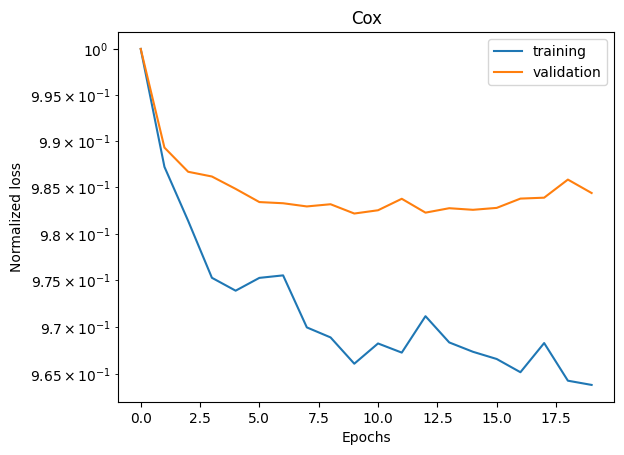

Model saved to cox_model_fold_5.pt
C-Index: 0.67616
Stratified C-Index: 0.66078
Confidence Interval: tensor([0.6493, 0.7030])

========================================| Fold 7 |========================================
Epoch: 0, Train Loss: 7.70376 Val Loss: 8.30147
Epoch: 1, Train Loss: 7.63882 Val Loss: 8.24659
Epoch: 2, Train Loss: 7.60311 Val Loss: 8.21992
Epoch: 3, Train Loss: 7.54165 Val Loss: 8.21518
Epoch: 4, Train Loss: 7.52713 Val Loss: 8.19954
Epoch: 5, Train Loss: 7.54691 Val Loss: 8.22010
Epoch: 6, Train Loss: 7.54413 Val Loss: 8.19709
Epoch: 7, Train Loss: 7.56775 Val Loss: 8.18620
Epoch: 8, Train Loss: 7.52556 Val Loss: 8.19984
Epoch: 9, Train Loss: 7.52464 Val Loss: 8.19516
Epoch: 10, Train Loss: 7.52965 Val Loss: 8.20148
Epoch: 11, Train Loss: 7.52086 Val Loss: 8.19732
Epoch: 12, Train Loss: 7.48775 Val Loss: 8.18363
Epoch: 13, Train Loss: 7.47560 Val Loss: 8.20798
Epoch: 14, Train Loss: 7.50669 Val Loss: 8.20058
Epoch: 15, Train Loss: 7.47722 Val Loss: 8.18597
Epoch: 1

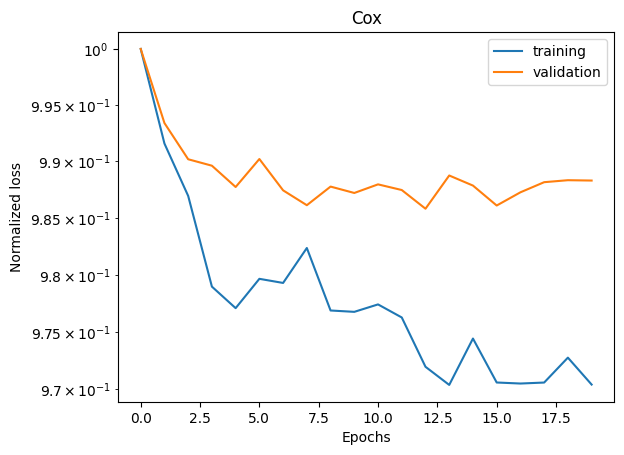

Model saved to cox_model_fold_6.pt
C-Index: 0.67213
Stratified C-Index: 0.64619
Confidence Interval: tensor([0.6452, 0.6991])

========================================| Fold 8 |========================================
Epoch: 0, Train Loss: 7.71841 Val Loss: 8.40779
Epoch: 1, Train Loss: 7.65280 Val Loss: 8.33645
Epoch: 2, Train Loss: 7.57969 Val Loss: 8.30993
Epoch: 3, Train Loss: 7.58482 Val Loss: 8.30592
Epoch: 4, Train Loss: 7.56955 Val Loss: 8.30593
Epoch: 5, Train Loss: 7.53485 Val Loss: 8.29163
Epoch: 6, Train Loss: 7.55630 Val Loss: 8.29805
Epoch: 7, Train Loss: 7.51487 Val Loss: 8.29994
Epoch: 8, Train Loss: 7.55551 Val Loss: 8.28636
Epoch: 9, Train Loss: 7.53686 Val Loss: 8.29332
Epoch: 10, Train Loss: 7.48842 Val Loss: 8.29854
Epoch: 11, Train Loss: 7.52422 Val Loss: 8.29850
Epoch: 12, Train Loss: 7.49131 Val Loss: 8.30363
Epoch: 13, Train Loss: 7.49761 Val Loss: 8.27582
Epoch: 14, Train Loss: 7.50610 Val Loss: 8.28251
Epoch: 15, Train Loss: 7.50754 Val Loss: 8.28939
Epoch: 1

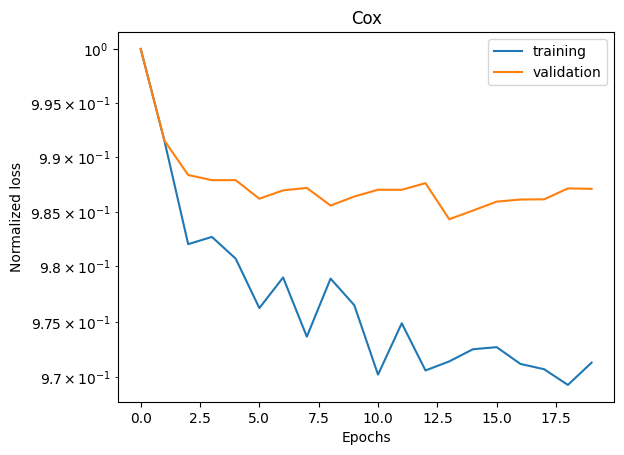

Model saved to cox_model_fold_7.pt
C-Index: 0.67057
Stratified C-Index: 0.65331
Confidence Interval: tensor([0.6436, 0.6975])

========================================| Fold 9 |========================================
Epoch: 0, Train Loss: 7.74853 Val Loss: 8.30918
Epoch: 1, Train Loss: 7.63927 Val Loss: 8.26651
Epoch: 2, Train Loss: 7.60128 Val Loss: 8.23977
Epoch: 3, Train Loss: 7.57940 Val Loss: 8.21202
Epoch: 4, Train Loss: 7.55748 Val Loss: 8.20181
Epoch: 5, Train Loss: 7.52851 Val Loss: 8.20379
Epoch: 6, Train Loss: 7.51217 Val Loss: 8.19632
Epoch: 7, Train Loss: 7.50742 Val Loss: 8.19125
Epoch: 8, Train Loss: 7.51592 Val Loss: 8.19444
Epoch: 9, Train Loss: 7.52928 Val Loss: 8.17915
Epoch: 10, Train Loss: 7.50114 Val Loss: 8.19662
Epoch: 11, Train Loss: 7.53203 Val Loss: 8.19240
Epoch: 12, Train Loss: 7.50023 Val Loss: 8.20056
Epoch: 13, Train Loss: 7.49945 Val Loss: 8.18766
Epoch: 14, Train Loss: 7.47867 Val Loss: 8.20119
Epoch: 15, Train Loss: 7.51170 Val Loss: 8.19127
Epoch: 1

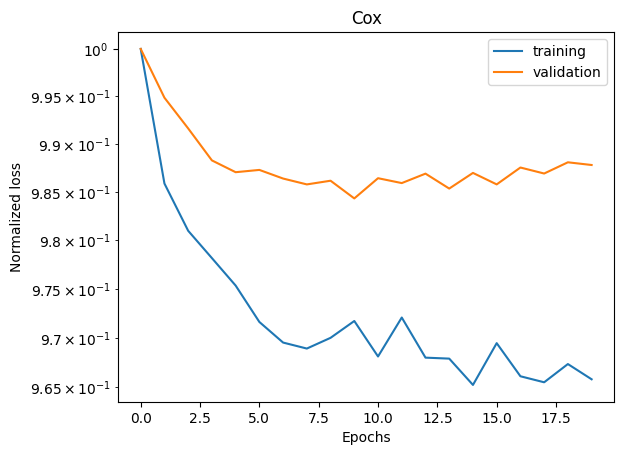

Model saved to cox_model_fold_8.pt
C-Index: 0.66285
Stratified C-Index: 0.63957
Confidence Interval: tensor([0.6359, 0.6898])

=======================================| Fold 10 |========================================
Epoch: 0, Train Loss: 7.74747 Val Loss: 8.32715
Epoch: 1, Train Loss: 7.68415 Val Loss: 8.25776
Epoch: 2, Train Loss: 7.58706 Val Loss: 8.23602
Epoch: 3, Train Loss: 7.56176 Val Loss: 8.21495
Epoch: 4, Train Loss: 7.57207 Val Loss: 8.19985
Epoch: 5, Train Loss: 7.57321 Val Loss: 8.20384
Epoch: 6, Train Loss: 7.54556 Val Loss: 8.20900
Epoch: 7, Train Loss: 7.52654 Val Loss: 8.20108
Epoch: 8, Train Loss: 7.55559 Val Loss: 8.20670
Epoch: 9, Train Loss: 7.51906 Val Loss: 8.21422
Epoch: 10, Train Loss: 7.55698 Val Loss: 8.20347
Epoch: 11, Train Loss: 7.50012 Val Loss: 8.21540
Epoch: 12, Train Loss: 7.51880 Val Loss: 8.21522
Epoch: 13, Train Loss: 7.49925 Val Loss: 8.21699
Epoch: 14, Train Loss: 7.50363 Val Loss: 8.21536
Epoch: 15, Train Loss: 7.49922 Val Loss: 8.21746
Epoch: 1

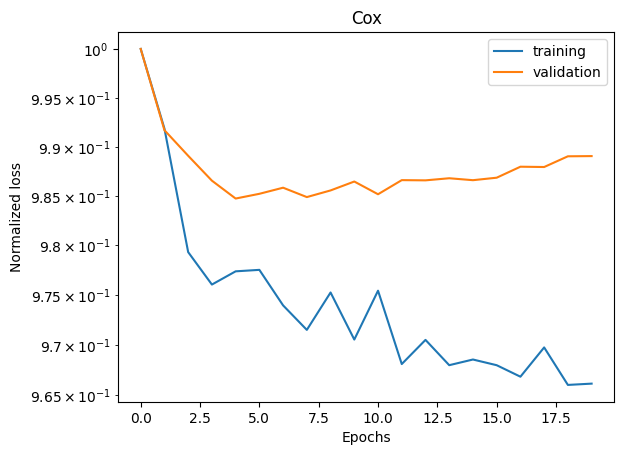

Model saved to cox_model_fold_9.pt
C-Index: 0.66759
Stratified C-Index: 0.65669
Confidence Interval: tensor([0.6402, 0.6950])


CV: 0.65067


In [9]:
dataloader_test = DataLoader(
    Custom_dataset(test_df), batch_size=len(test_df), shuffle=False
)

folds = 10
models = list()
oof_ts = np.zeros(len(train_df))

fold_scores = list()
for idx in range(folds):

    model_save_path = f"/kaggle/working/fold_{idx}/"
    
    print(f"| Fold {idx+1} |".center(90, "="))
    train_index = train_df[train_df["fold"]!=idx].index
    val_index = train_df[train_df["fold"]==idx].index

    train = train_df.loc[train_index]
    train.drop(["fold"], axis=1, inplace=True)
    val = train_df.loc[val_index]
    val.drop(["fold"], axis=1, inplace=True)
    
    dataloader_train = DataLoader(
        Custom_dataset(train), batch_size=config.batch_size, shuffle=True
    )
    dataloader_val = DataLoader(
        Custom_dataset(val), batch_size=len(train_df.loc[val_index]), shuffle=False
    )

    num_features = next(iter(dataloader_train))[0].size(1)
    cox_model = load_cox_model(num_features)
    optimizer = torch.optim.Adam(cox_model.parameters(), lr=config.learning_rate)
    
    cox_model = train_model(cox_model, optimizer, dataloader_train, dataloader_val, config.epochs)
    log_hz, event, time = infer(cox_model, dataloader_val)
    models.append(cox_model)

    cox_cindex = ConcordanceIndex()
    fold_score = validate_model(eval_df.loc[val_index], log_hz.view(-1).numpy())
    fold_scores.append(fold_score)

    oof_ts[val_index] = log_hz.view(-1).numpy()

    model_save_path = f"cox_model_fold_{idx}.pt"
    torch.save(cox_model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    print(f"C-Index: {cox_cindex(log_hz, event, time):.5f}")
    print(f"Stratified C-Index: {fold_score:.5f}")
    print(f"Confidence Interval: {cox_cindex.confidence_interval()}\n")

print(f"\nCV: {np.mean(fold_scores):.5f}")

# 6. Saving Submission

In [10]:
sub = pd.read_csv(config.sub_path)
test_preds = np.zeros(len(test_df))

for model in tqdm(models):
    test_preds += infer(model, dataloader_test)[0].view(-1).numpy() / len(models)

sub["prediction"] = test_preds
sub.to_csv("submission.csv", index=False)
sub.head()

100%|██████████| 10/10 [00:00<00:00, 260.35it/s]


,ID,prediction
0,28800,-1.839347
1,28801,-0.225037
2,28802,-2.425640


In [11]:
train_df["predictions"] = oof_ts
train_df.to_parquet("ts_exp_01_oof.parquet")